In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import os, sys

import requests
import keras

from keras.utils import get_file

from keras.preprocessing.text import Tokenizer

from keras import layers
from keras.layers import TextVectorization, LeakyReLU, Conv2DTranspose, Embedding, Bidirectional, Reshape, Dense, BatchNormalization, LSTM
from keras.layers import GRU, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Dropout, MultiHeadAttention, LayerNormalization, Add, StringLookup
from keras import Sequential
from keras.models import save_model, load_model

import tensorflow as tf


from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

from skimage import color
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

np.random.seed(1000)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Image generation

In [2]:
Street = 'Train/Street/'
Sea = 'Train/Sea/'

In [3]:
data_street = [Street+f for f in listdir(Street) if isfile(join(Street, f))]
data_sea = [Sea+f for f in listdir(Sea) if isfile(join(Sea, f))]


files = data_street + data_sea 

In [4]:
from skimage.transform import  resize
from skimage import io

def image_transform(paths):
    x = []
    for path in paths:
        image = io.imread(path)
        image_res = resize(image,  (32, 32))
        x.append(image_res)
    return x

In [5]:
x = image_transform(files[0:1000])

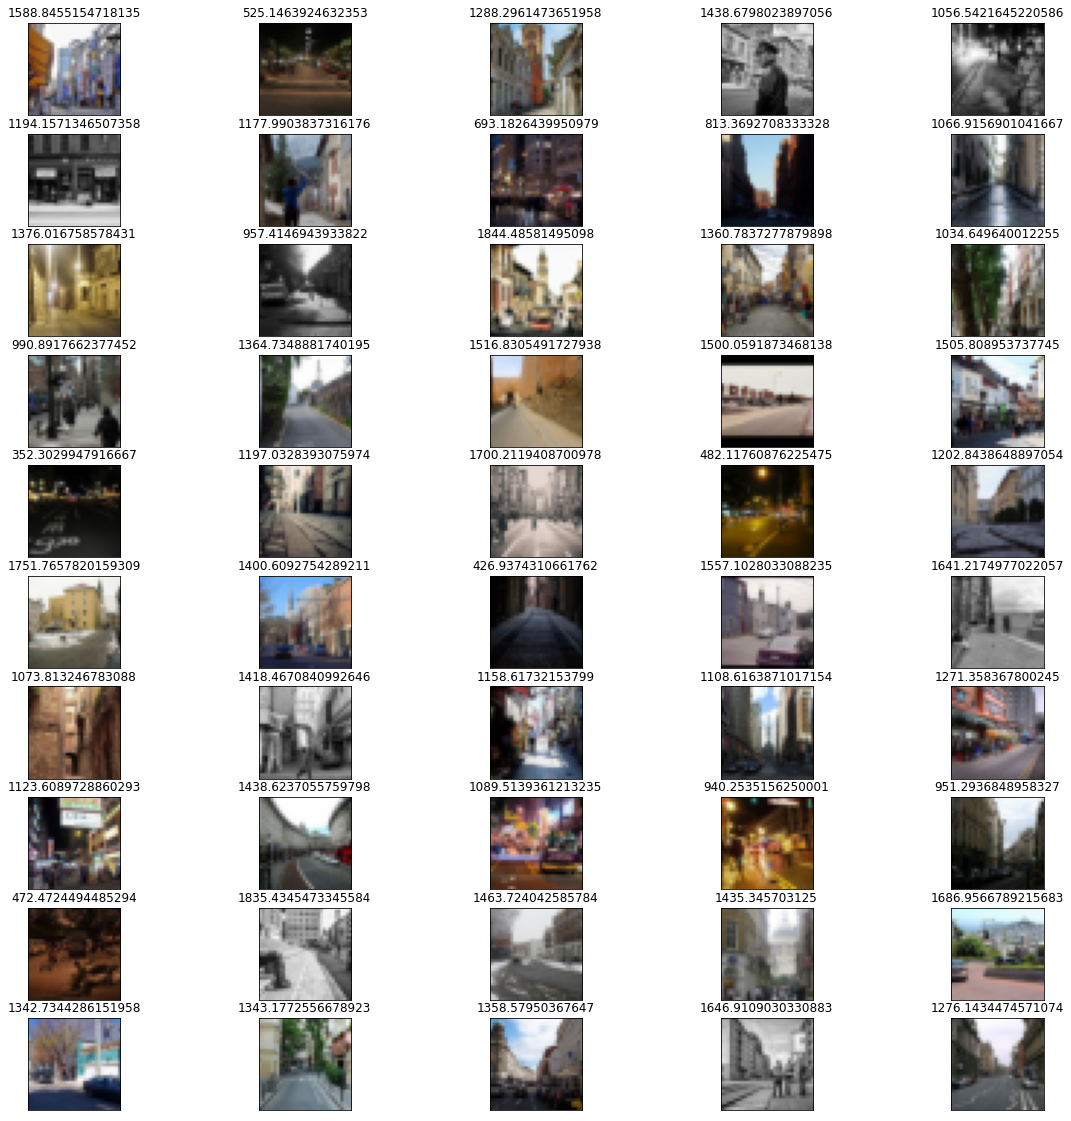

In [6]:
fig = plt.figure(figsize=(20,20))
for row in range(10):
    for column in range(5):
        i = row * 5 + column
        if i>len(x)-1:
            break                   
        ax = fig.add_subplot(10, 5, i+1)
        ax.set_title(str(np.sum(x[i])))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(x[i])

In [7]:
latent_dim = 100

In [8]:
x_train = np.clip(x, -1, 1)
x_train.shape

(1000, 32, 32, 3)

In [9]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [10]:
def build_discriminator():
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

In [11]:
def build_generator():
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model   

In [12]:
def build_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [13]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    # scale from [-1,1] to [0,1]
    generated_images = (generated_images + 1) / 2.0
    
    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [14]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [15]:
def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        with HiddenPrints():
            for i in range(num_batches):
                noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
                image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
                
                # Generate fake CIFAR images
                generated_images = generator.predict(noise)
                
                X = np.concatenate([image_batch, generated_images])

                # Labels for generated and real data
                y_dis = np.zeros(2*batch_size)
                y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
                # Train discriminator
                discriminator.trainable = True
                d_loss, _ = discriminator.train_on_batch(X, y_dis)
                discrim_losses.append(d_loss)

                # Train generator
                noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
                y_gen = np.ones(batch_size)
                discriminator.trainable = False
                gan.train_on_batch(noise, y_gen)
        if ep % 10 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)
            tf.keras.backend.clear_session()  

In [16]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        with HiddenPrints():
            for i in range(num_batches):
                noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
                image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
                
                # Generate fake CIFAR images
                generated_images = generator.predict(noise)
                
                X = np.concatenate([image_batch, generated_images])

                # Labels for generated and real data
                y_dis = np.zeros(2*batch_size)
                y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
                # Train discriminator
                discriminator.trainable = True
                d_loss, _ = discriminator.train_on_batch(X, y_dis)
                discrim_losses.append(d_loss)

                # Train generator
                noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
                y_gen = np.ones(batch_size)
                discriminator.trainable = False
                gan.train_on_batch(noise, y_gen)
        if ep % 10 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)
            tf.keras.backend.clear_session()  
     

In [17]:
discrim_losses = []
acc = []
all_images = []

discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)

epoch:  0
1/1 [==============================] - 0s 53ms/step


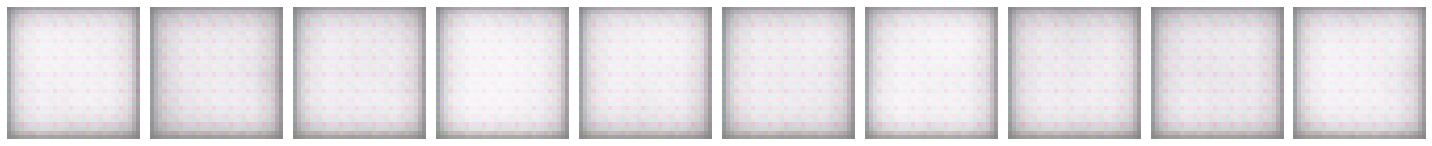

epoch:  10
1/1 [==============================] - 0s 56ms/step


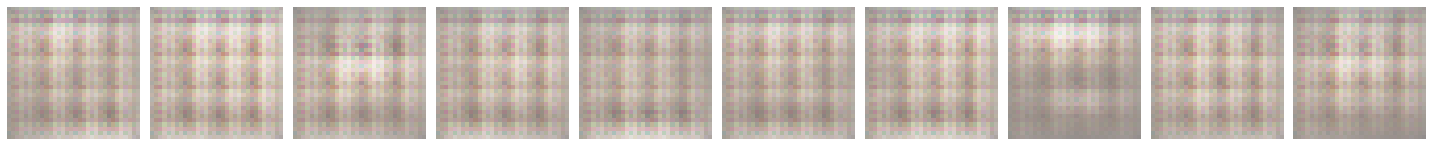

epoch:  20
1/1 [==============================] - 0s 64ms/step


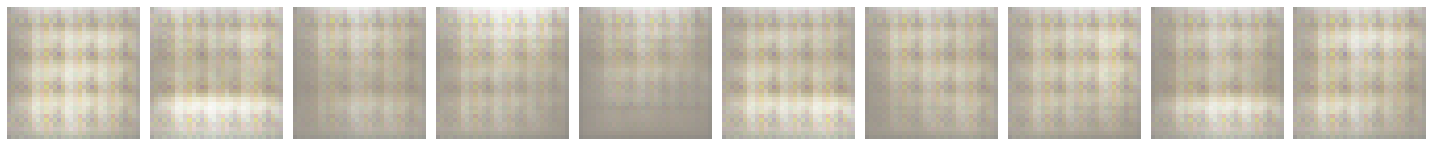

epoch:  30
1/1 [==============================] - 0s 65ms/step


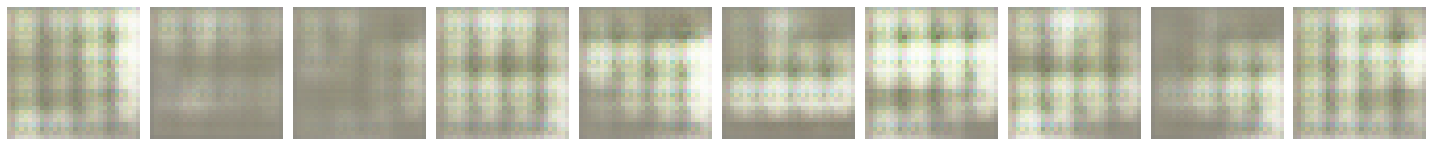

epoch:  40
1/1 [==============================] - 0s 67ms/step


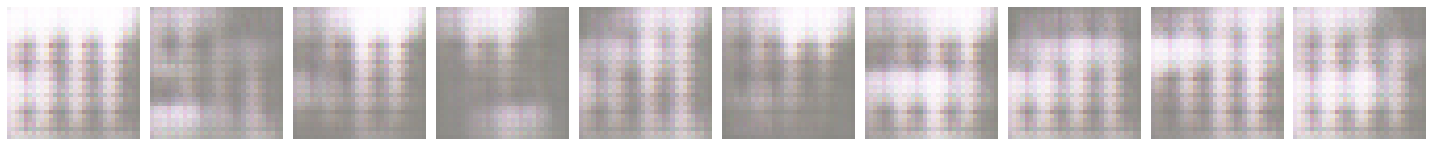

epoch:  50
1/1 [==============================] - 0s 56ms/step


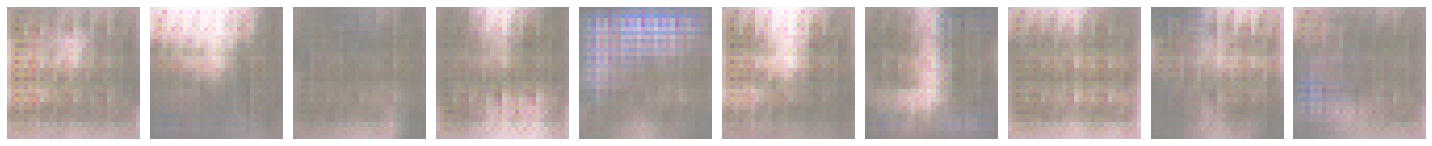

epoch:  60
1/1 [==============================] - 0s 62ms/step


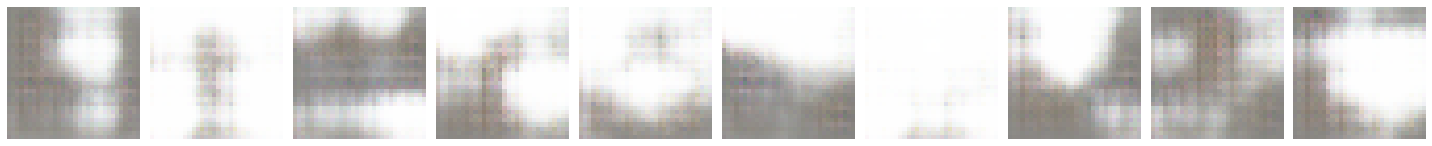

epoch:  70
1/1 [==============================] - 0s 59ms/step


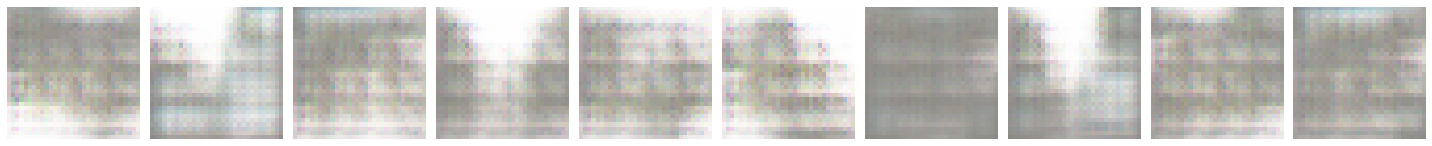

epoch:  80
1/1 [==============================] - 0s 69ms/step


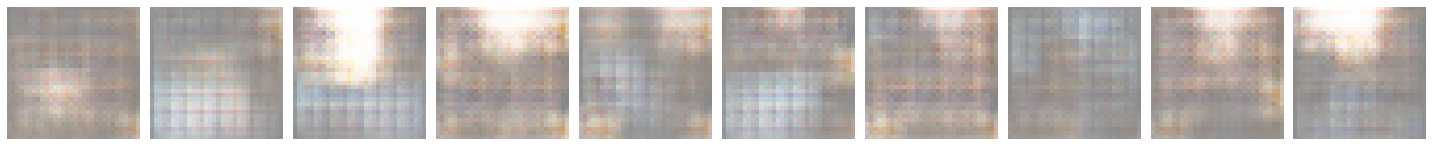

epoch:  90
1/1 [==============================] - 0s 68ms/step


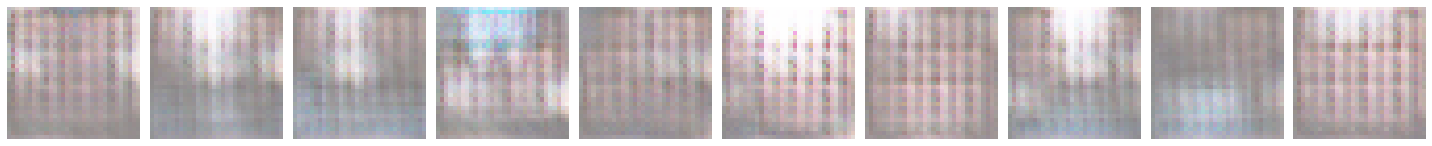

epoch:  100
1/1 [==============================] - 0s 69ms/step


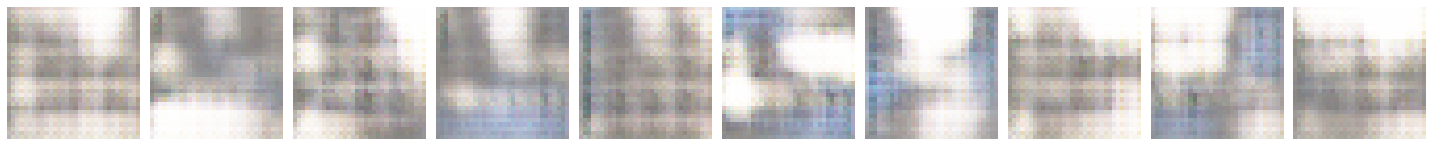

epoch:  110
1/1 [==============================] - 0s 70ms/step


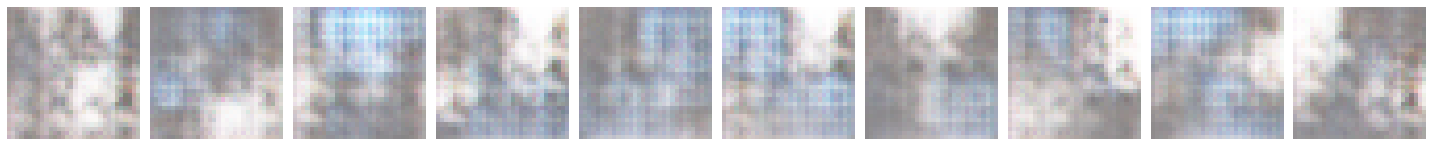

epoch:  120
1/1 [==============================] - 0s 69ms/step


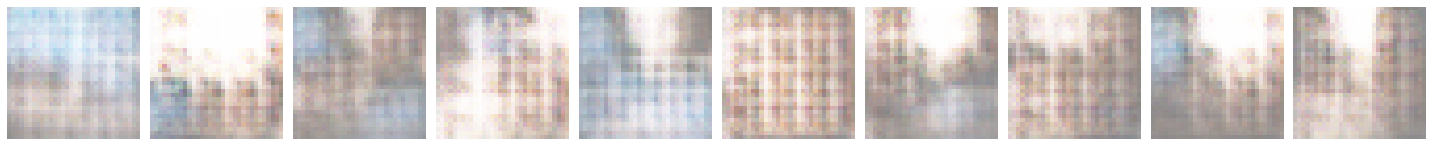

In [18]:
epochs = 120# to get good quality images, you should train the model for more than 100 epochs
batch_size = 100
train_model(epochs, batch_size)